In [1]:
import datasets
import albumentations as A
from PIL import Image as PILImage
import matplotlib.pyplot as plt

import os
import cv2
import numpy as np
import pandas as pd
import albumentations
from PIL import Image, ImageOps, ImageEnhance
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations import functional as F
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from albumentations.pytorch.transforms import ToTensorV2
from timm.data.mixup import Mixup
from timm.data import create_loader
import torchvision
import copy

In [3]:
classes = ['Porygon', 'Goldeen', 'Hitmonlee', 'Hitmonchan', 'Gloom', 'Aerodactyl', 'Mankey', 'Seadra', 'Gengar', 'Venonat', 'Articuno', 'Seaking', 'Dugtrio', 'Machop', 'Jynx', 'Oddish', 'Dodrio', 'Dragonair', 'Weedle', 'Golduck', 'Flareon', 'Krabby', 'Parasect', 'Ninetales', 'Nidoqueen', 'Kabutops', 'Drowzee', 'Caterpie', 'Jigglypuff', 'Machamp', 'Clefairy', 'Kangaskhan', 'Dragonite', 'Weepinbell', 'Fearow', 'Bellsprout', 'Grimer', 'Nidorina', 'Staryu', 'Horsea', 'Electabuzz', 'Dratini', 'Machoke', 'Magnemite', 'Squirtle', 'Gyarados', 'Pidgeot', 'Bulbasaur', 'Nidoking', 'Golem', 'Dewgong', 'Moltres', 'Zapdos', 'Poliwrath', 'Vulpix', 'Beedrill', 'Charmander', 'Abra', 'Zubat', 'Golbat', 'Wigglytuff', 'Charizard', 'Slowpoke', 'Poliwag', 'Tentacruel', 'Rhyhorn', 'Onix', 'Butterfree', 'Exeggcute', 'Sandslash', 'Pinsir', 'Rattata', 'Growlithe', 'Haunter', 'Pidgey', 'Ditto', 'Farfetchd', 'Pikachu', 'Raticate', 'Wartortle', 'Vaporeon', 'Cloyster', 'Hypno', 'Arbok', 'Metapod', 'Tangela', 'Kingler', 'Exeggutor', 'Kadabra', 'Seel', 'Voltorb', 'Chansey', 'Venomoth', 'Ponyta', 'Vileplume', 'Koffing', 'Blastoise', 'Tentacool', 'Lickitung', 'Paras', 'Clefable', 'Cubone', 'Marowak', 'Nidorino', 'Jolteon', 'Muk', 'Magikarp', 'Slowbro', 'Tauros', 'Kabuto', 'Spearow', 'Sandshrew', 'Eevee', 'Kakuna', 'Omastar', 'Ekans', 'Geodude', 'Magmar', 'Snorlax', 'Meowth', 'Pidgeotto', 'Venusaur', 'Persian', 'Rhydon', 'Starmie', 'Charmeleon', 'Lapras', 'Alakazam', 'Graveler', 'Psyduck', 'Rapidash', 'Doduo', 'Magneton', 'Arcanine', 'Electrode', 'Omanyte', 'Poliwhirl', 'Mew', 'Alolan Sandslash', 'Mewtwo', 'Weezing', 'Gastly', 'Victreebel', 'Ivysaur', 'MrMime', 'Shellder', 'Scyther', 'Diglett', 'Primeape', 'Raichu']

num_classes = len(classes)

In [2]:
def display_images(
    images,
    columns=5,
    width=20,
    height=8,
    max_images=15,
    label_wrap_length=50,
    label_font_size=8,
):
    if not images:
        print("No images to display.")
        return

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images = images[0:max_images]

    height = max(height, int(len(images) / columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)
        

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


## Hyperparams

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 4

In [5]:
dataset = datasets.load_dataset("keremberke/pokemon-classification",name="full")

selected_columns = ['image','labels']
train_ds = dataset['train'].select_columns(selected_columns).shuffle()
val_ds = dataset['validation'].select_columns(selected_columns).shuffle()
test_ds = dataset['test'].select_columns(selected_columns)


Found cached dataset pokemon-classification (/home/yslee/.cache/huggingface/datasets/keremberke___pokemon-classification/full/1.0.0/5193d0f863ed08164636296506df483caa6c9965bc05198ec2136417398e4b28)


  0%|          | 0/3 [00:00<?, ?it/s]

In [50]:
transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(),
        ToTensorV2(),
    ]
)

def train_transform(batch):
    image = [np.array(image) for image in batch["image"]]
    image = [transform(image=image_)["image"] for image_ in image]
    batch["image"] = image
    return batch


train_ds.set_transform(train_transform)

In [7]:
def collate_fn(batch):
    images = [row["image"] for row in batch]
    images = torch.stack(images)
    labels = torch.tensor([row["labels"] for row in batch]).long()
    return {"images": images, "labels": labels}


train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)


In [8]:


# print(images.shape,labels.shape)

# Mixup

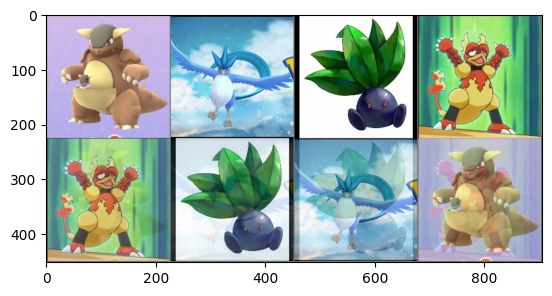

In [15]:
mixup_args = {
    "mixup_alpha": 1.0,
    "cutmix_alpha": 0.0,
    "cutmix_minmax": None,
    "prob": 1.0,
    "switch_prob": 0.0,
    "mode": "batch",
    "label_smoothing": 0,
    "num_classes": num_classes,
}

"""
    Args:
        mixup_alpha (float): mixup alpha value, mixup is active if > 0.
        cutmix_alpha (float): cutmix alpha value, cutmix is active if > 0.
        cutmix_minmax (List[float]): cutmix min/max image ratio, cutmix is active and uses this vs alpha if not None.
        prob (float): probability of applying mixup or cutmix per batch or element
        switch_prob (float): probability of switching to cutmix instead of mixup when both are active
        mode (str): how to apply mixup/cutmix params (per 'batch', 'pair' (pair of elements), 'elem' (element)
        correct_lam (bool): apply lambda correction when cutmix bbox clipped by image borders
        label_smoothing (float): apply label smoothing to the mixed target tensor
        num_classes (int): number of classes for target
"""
batch = next(iter(train_dl))
images = batch['images']
labels = batch['labels']
mixup_fn = Mixup(**mixup_args)
images_, labels_ = mixup_fn(copy.deepcopy(images), labels)
out = torchvision.utils.make_grid(torch.cat([images, images_], dim=2))
imshow(out)

# Cutmix

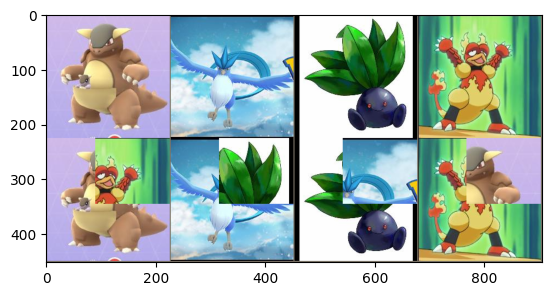

In [91]:
mixup_args = {
    "mixup_alpha": 0.0,
    "cutmix_alpha": 0.5,
    "cutmix_minmax": None,
    "prob": 1.0,
    "switch_prob": 0.0,
    "mode": "batch",
    "label_smoothing": 0,
    "num_classes": num_classes,
}

"""
    Args:
        mixup_alpha (float): mixup alpha value, mixup is active if > 0.
        cutmix_alpha (float): cutmix alpha value, cutmix is active if > 0.
        cutmix_minmax (List[float]): cutmix min/max image ratio, cutmix is active and uses this vs alpha if not None.
        prob (float): probability of applying mixup or cutmix per batch or element
        switch_prob (float): probability of switching to cutmix instead of mixup when both are active
        mode (str): how to apply mixup/cutmix params (per 'batch', 'pair' (pair of elements), 'elem' (element)
        correct_lam (bool): apply lambda correction when cutmix bbox clipped by image borders
        label_smoothing (float): apply label smoothing to the mixed target tensor
        num_classes (int): number of classes for target
"""
del mixup_fn
batch = next(iter(train_dl))
images = batch["images"]
labels = batch["labels"]
mixup_fn = Mixup(**mixup_args)
images_, labels_ = mixup_fn(copy.deepcopy(images), labels)
out = torchvision.utils.make_grid(torch.cat([images, images_], dim=2))
imshow(out)


# Element-wise Mixup

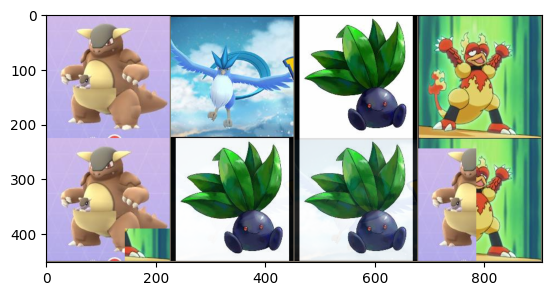

In [47]:
mixup_args = {
    "mixup_alpha": 0.3,
    "cutmix_alpha": 0.3,
    "cutmix_minmax": None,
    "prob": 1.0,
    "switch_prob": 0.5,
    "mode": "elem",
    "label_smoothing": 0,
    "num_classes": num_classes,
}
"""
    Args:
        mixup_alpha (float): mixup alpha value, mixup is active if > 0.
        cutmix_alpha (float): cutmix alpha value, cutmix is active if > 0.
        cutmix_minmax (List[float]): cutmix min/max image ratio, cutmix is active and uses this vs alpha if not None.
        prob (float): probability of applying mixup or cutmix per batch or element
        switch_prob (float): probability of switching to cutmix instead of mixup when both are active
        mode (str): how to apply mixup/cutmix params (per 'batch', 'pair' (pair of elements), 'elem' (element)
        correct_lam (bool): apply lambda correction when cutmix bbox clipped by image borders
        label_smoothing (float): apply label smoothing to the mixed target tensor
        num_classes (int): number of classes for target
"""
del mixup_fn
batch = next(iter(train_dl))
images = batch["images"]
labels = batch["labels"]
mixup_fn = Mixup(**mixup_args)
images_, labels_ = mixup_fn(copy.deepcopy(images), labels)
out = torchvision.utils.make_grid(torch.cat([images, images_], dim=2))
imshow(out)
